# Load and wrangle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.formula.api as smf

In [2]:
# Load dataframes
df_cross = pd.read_csv("aau1043_dnm.tsv")
df_age = pd.read_csv("aau1043_parental_age.tsv")
df_cross.head()

,Chr,Pos,Ref,Alt,Proband_id,Phase_combined,Crossover,Sanger
0,chr1,241097646,C,T,99379,father,paternal_crossover,confirmed
1,chr10,29202943,A,G,8147,father,maternal_crossover,PCR failed
2,chr11,129441657,C,T,5410,mother,maternal_crossover,confirmed
3,chr13,96867147,A,G,46025,father,paternal_crossover,confirmed
4,chr17,50609998,C,T,144769,mother,maternal_crossover,confirmed


In [3]:
df_cross.drop(["Chr", "Pos", "Ref", "Alt"], axis = 1, inplace = True)
df_cross

,Proband_id,Phase_combined,Crossover,Sanger
0,99379,father,paternal_crossover,confirmed
1,8147,father,maternal_crossover,PCR failed
2,5410,mother,maternal_crossover,confirmed
3,46025,father,paternal_crossover,confirmed
4,144769,mother,maternal_crossover,confirmed
...,...,...,...,...
26426,54383,father,NaN,NaN
26427,39729,father,NaN,NaN
26428,17904,mother,NaN,NaN
26429,80108,father,NaN,NaN


In [4]:
df_mother = pd.DataFrame(df_cross[df_cross['Phase_combined']=="mother"]["Proband_id"].value_counts().rename_axis(["Proband_id"]).reset_index(name = 'mat_dnm'))
df_father = pd.DataFrame(df_cross[df_cross['Phase_combined']=="father"]["Proband_id"].value_counts().rename_axis(["Proband_id"]).reset_index(name = 'pat_dnm'))
df_father.head()

,Proband_id,pat_dnm
0,91410,111
1,114094,98
2,111288,93
3,99984,91
4,64166,88


In [5]:
df_tot = pd.DataFrame(df_cross.Proband_id.value_counts().rename_axis(["Proband_id"]).reset_index(name = 'tot_dnm'))
df_tot

,Proband_id,tot_dnm
0,91410,122
1,114094,121
2,111288,115
3,8147,114
4,88246,113
...,...,...
391,121087,37
392,62630,34
393,76504,34
394,37789,34


In [6]:
# Merge on proband id
df_intermediate = df_father.merge(df_mother, on="Proband_id")
df_intermediate

,Proband_id,pat_dnm,mat_dnm
0,91410,111,10
1,114094,98,22
2,111288,93,21
3,99984,91,12
4,64166,88,16
...,...,...,...
391,76504,27,5
392,1097,26,12
393,13990,25,7
394,36430,25,16


In [7]:
df_final = df_intermediate.merge(df_tot, on="Proband_id")

In [8]:
df_final

,Proband_id,pat_dnm,mat_dnm,tot_dnm
0,91410,111,10,122
1,114094,98,22,121
2,111288,93,21,115
3,99984,91,12,103
4,64166,88,16,105
...,...,...,...,...
391,76504,27,5,34
392,1097,26,12,39
393,13990,25,7,33
394,36430,25,16,42


In [9]:
df_age.head()

,Proband_id,Father_age,Mother_age
0,675,31,36
1,1097,19,19
2,1230,30,28
3,1481,32,20
4,1806,38,34


In [10]:
df_reg = df_final.merge(df_age, on = "Proband_id")
df_reg

,Proband_id,pat_dnm,mat_dnm,tot_dnm,Father_age,Mother_age
0,91410,111,10,122,51,34
1,114094,98,22,121,51,44
2,111288,93,21,115,53,44
3,99984,91,12,103,51,41
4,64166,88,16,105,41,40
...,...,...,...,...,...,...
391,76504,27,5,34,19,17
392,1097,26,12,39,19,19
393,13990,25,7,33,16,17
394,36430,25,16,42,35,26


# Linear regression

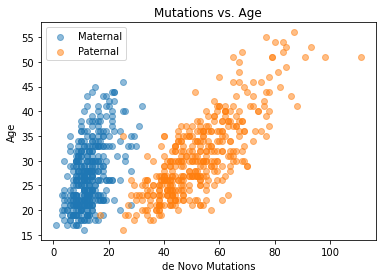

In [11]:
fig, ax = plt.subplots()
ax.scatter(df_reg['mat_dnm'], df_reg['Mother_age'], alpha = 0.5, label = "Maternal")
ax.scatter(df_reg['pat_dnm'], df_reg['Father_age'], alpha = 0.5, label = "Paternal")
ax.set_title('Mutations vs. Age')
ax.set_xlabel('de Novo Mutations')
ax.set_ylabel('Age')

plt.legend()
plt.show()

In [12]:
m_model = smf.ols(formula = "mat_dnm ~ 1 + Mother_age", data = df_reg).fit()
m_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mat_dnm   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     116.0
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           6.88e-24
Time:                        15:15:05   Log-Likelihood:                -1158.1
No. Observations:                 396   AIC:                             2320.
Df Residuals:                     394   BIC:                             2328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5040      0.981      2.553      0.011       0.576       4.432
Mother_age     0.3776      0.035     10.772      0.000       0.309       0.446
==============================================================================
Omnibus:                       51.143   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.501
Skew:                           0.845   Prob(JB):                     4.03e-17
Kurtosis:                       4.310   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is significant because the p-val < 0.05

In [13]:
f_model = smf.ols(formula = "pat_dnm ~ 1 + Father_age", data = df_reg).fit()
f_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pat_dnm   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     639.6
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           1.55e-84
Time:                        15:15:05   Log-Likelihood:                -1406.6
No. Observations:                 396   AIC:                             2817.
Df Residuals:                     394   BIC:                             2825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3263      1.702      6.066      0.000       6.979      13.673
Father_age     1.3538      0.054     25.291      0.000       1.249       1.459
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   1.183
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.185
Skew:                           0.256   Prob(JB):                       0.0167
Kurtosis:                       3.483   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is significant because the p-val < 0.05

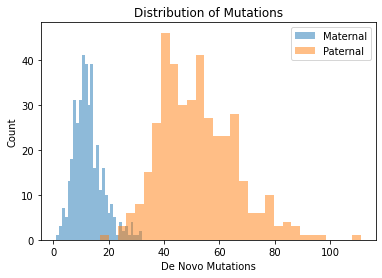

In [23]:
fig, ax = plt.subplots()
ax.hist(df_reg['mat_dnm'], bins = 30, alpha = 0.5, label = 'Maternal')
ax.hist(df_reg['pat_dnm'], bins = 30, alpha = 0.5, label = 'Paternal')
ax.set_title('Distribution of Mutations')
ax.set_xlabel('De Novo Mutations')
ax.set_ylabel('Count')

plt.legend()
plt.show()

In [15]:
stats.ttest_ind(df_reg['mat_dnm'], df_reg['pat_dnm'])

Ttest_indResult(statistic=-53.403565287269245, pvalue=2.1986031793078793e-264)

Low p-val > Significantly different
Based on the plots themselves, you can see how different the means of the maternal and paternal mutation frequency is

# Poisson regression

In [16]:
m_model = smf.poisson(formula = "mat_dnm ~ 1 + Mother_age", data = df_reg).fit()
m_model.summary()

Optimization terminated successfully.
         Current function value: 2.927974
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                mat_dnm   No. Observations:                  396
Model:                        Poisson   Df Residuals:                      394
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                 0.07164
Time:                        15:15:06   Log-Likelihood:                -1159.5
converged:                       True   LL-Null:                       -1248.9
Covariance Type:            nonrobust   LLR p-value:                 8.241e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7671      0.060     29.235      0.000       1.649       1.886
Mother_age     0.0281      0.002     13.582      0.000       0.024       0.032
==============================================================================
"""

In [17]:
f_model = smf.poisson(formula = "pat_dnm ~ 1 + Father_age", data = df_reg).fit()
f_model.summary()

Optimization terminated successfully.
         Current function value: 3.578620
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                pat_dnm   No. Observations:                  396
Model:                        Poisson   Df Residuals:                      394
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                  0.2277
Time:                        15:15:06   Log-Likelihood:                -1417.1
converged:                       True   LL-Null:                       -1834.9
Covariance Type:            nonrobust   LLR p-value:                1.004e-183
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1903      0.027    116.856      0.000       3.137       3.244
Father_age     0.0241      0.001     29.608      0.000       0.023       0.026
==============================================================================
"""

In [18]:
new_observation = pd.DataFrame({"Father_age": [50.5]})

In [19]:
f_model.predict(new_observation)

0    82.031316
dtype: float64